<a href="https://colab.research.google.com/github/sanha-hwang/ocular_disease/blob/main/ocular_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>Project4_level1: 목표

1. 캐글에서 안구질환 인식 데이터를 받아 안구질환을 진단하는 모델을 만들어보자

2. 5000명의 환자의 안저 사진 데이터가 있고 라벨로는
일반 : N, 당뇨병 : D, 녹내장 : G, 백내장 : C, 연령 관련 황반변성 : A
고혈압 : H, 병적 근시 : M, 기타 질병 / 이상 : O

Normal (N),
Diabetes (D),
Glaucoma (G),
Cataract (C),
Age related Macular Degeneration (A),
Hypertension (H),
Pathological Myopia (M),
Other diseases/abnormalities (O)

3. 이미지 분류 잘하는 모델 만들기 목표 80프로 이상

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow
from tensorflow import keras


In [43]:
base_dir = '/content/drive/MyDrive/Input/ocular-disease-recognition-odir-5k/ODIR-5K'

train_dir = os.path.join(base_dir,'Training Images')
dataset_path = os.path.join(base_dir,'data.xlsx')

train_fname = os.listdir(train_dir)

In [44]:
dataset = pd.read_excel(dataset_path)
dataset.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [45]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(dataset, test_size= 0.2, random_state= 42)

train_data.shape, validation_data.shape

((2800, 15), (700, 15))

In [47]:
#traindata를 trainset, validationset로 분리 및 폴더설정
# os.mkdir('/content/drive/MyDrive/Input/ocular-disease-recognition-odir-5k/ODIR-5K/Training Images/train_set')
# os.mkdir('/content/drive/MyDrive/Input/ocular-disease-recognition-odir-5k/ODIR-5K/Training Images/validation_set')



In [48]:
trainset_dir = os.path.join(train_dir,'train_set')
validation_dir = os.path.join(train_dir,'validation_set')


In [49]:
#폴더 이동, 경로는 활용
data_ID = dataset['ID'].values
train_ID = train_data['ID'].values

import shutil

for id in data_ID:
  left_filename = '/'+str(id)+'_left.jpg' 
  right_filename = '/'+str(id)+'_right.jpg'
  
  if id in train_ID:
    shutil.move(train_dir + left_filename, trainset_dir + left_filename)
    shutil.move(train_dir + right_filename, trainset_dir + right_filename)
  else:
    shutil.move(train_dir + left_filename, validation_dir + left_filename)
    shutil.move(train_dir + right_filename, validation_dir + right_filename)
  

In [51]:
len(os.listdir(trainset_dir)), len(os.listdir(validation_dir))

(5600, 1400)

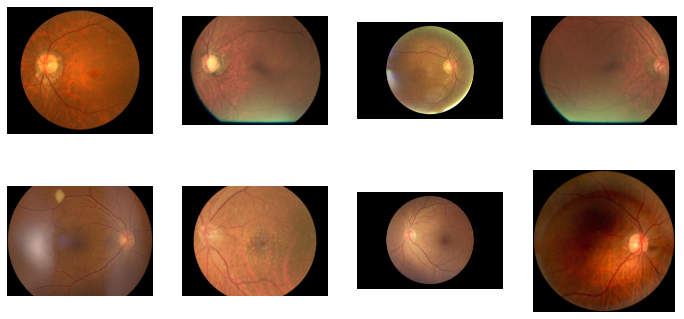

In [7]:
#번외편 이미지 한번 눈으로 확인해보기
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_forest_pix = [os.path.join(train_dir, fname)
                for fname in train_fname[pic_index-8:pic_index]]

for i, img_path in enumerate(next_forest_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [13]:
#Step. model define 

from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

Num_classes = 8 # N, D, G, C, A, H, M, O

channels = 3 # 입력 이미지의 차원수 : RBG

#학습된 네트워크 Resnet50
image_size =224
resnet_pooling_average = 'avg'
dense_layer_activation = 'softmax'
objective_function = 'categorical_crossentropy'

#출력 metrics
loss_metrics = ['accuracy']

#early_stop
num_epochs = 10
early_stop_patience = 3

step_per_epoch_training = 10
step_per_epoch_validation = 10 

batch_size_training = 100
batch_size_validation = 100

batch_size_testing = 1

#Step model making

model = Sequential()
model.add(ResNet50(include_top = False, pooling = resnet_pooling_average))
model.add(Dense(Num_classes, activation = dense_layer_activation))

for layer in model.layers:
  layer.trainable = False

#Step model compiler

from tensorflow.keras import optimizers

model.compile(optimizer = 'adam', loss = objective_function, metrics = loss_metrics)

In [ ]:
# Step input image resize & augmentation

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rescale = 1.0/255.,
    preprocessing_function = preprocess_input,
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_state = 20,
    width_sift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True)

train_generator = data_generator.flow_from_directory(trainset_dir,
                                                     batch_size = batch_size_training,
                                                     class_mode = 'categorical')

validation_gen = ImageDataGenerator( rescale = 1.0/255.)
validation_generator = validation_gen.flow_from_directory(validation_dir,
                                                         batch_size = batch_size_training,
                                                         class_mode = 'categorical'))

In [ ]:
data_generator.fit(train_images)

In [ ]:
#Step model learning

model.fit(data_generator.flow(train_images, train_label, batch_size = 32), step_per_epoch = len(train_images)/ 32, epochs= num_epochs)